In [169]:
import pandas as pd
from sqlalchemy import create_engine
import config as banco
from urllib.parse import quote
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import category_encoders as ce
from sklearn.preprocessing import PowerTransformer
from datasist.structdata import detect_outliers

In [171]:
engine = create_engine("mysql+pymysql://" +banco.USER+ ":%s" % quote(banco.SENHA) +"@"+banco.HOST+":"+banco.PORT+"/"+banco.SCHEMA)
df = pd.read_sql('SELECT * FROM ' + banco.TABELA, con=engine)
df.head()

,metros_quadrados,quartos,banheiros,vagas,cidade,estado,preco
0,277000,--,--,--,MORRETES,PR,229000
1,69,2,1,1,SAO BERNARDO DO CAMPO,SP,310000
2,87,3,2,1,GUARUJA,SP,320000
3,50,2,1,1,SAO PAULO,SP,232000
4,250,4,3,8,ITARIRI,SP,480000


In [172]:
df.replace(' -- ', np.nan , inplace=True)
df_str = df[['cidade','estado']]
df = df[['metros_quadrados','quartos','banheiros','vagas','preco']]
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(df)
ndarray = imp.transform(df)
df = pd.DataFrame(ndarray, columns=['metros_quadrados','quartos','banheiros','vagas','preco'])

df['cidade'] = df_str['cidade']
df['estado'] = df_str['estado']

df[['metros_quadrados','quartos','banheiros','vagas']] =  df[['metros_quadrados','quartos','banheiros','vagas']].astype(int)

In [173]:
df.describe()

,metros_quadrados,quartos,banheiros,vagas,preco
count,7020.000000,7020.000000,7020.000000,7020.000000,7.020000e+03
mean,7820.888604,2.637892,2.443447,1.720798,8.039784e+05
std,45503.148615,0.947362,1.401999,1.444651,1.347603e+06
min,31.000000,1.000000,1.000000,1.000000,1.600000e+05
25%,63.750000,2.000000,2.000000,1.000000,3.387500e+05
50%,81.000000,3.000000,2.000000,1.000000,4.900000e+05
75%,120.000000,3.000000,3.000000,2.000000,6.900000e+05
max,277000.000000,6.000000,9.000000,8.000000,8.200000e+06


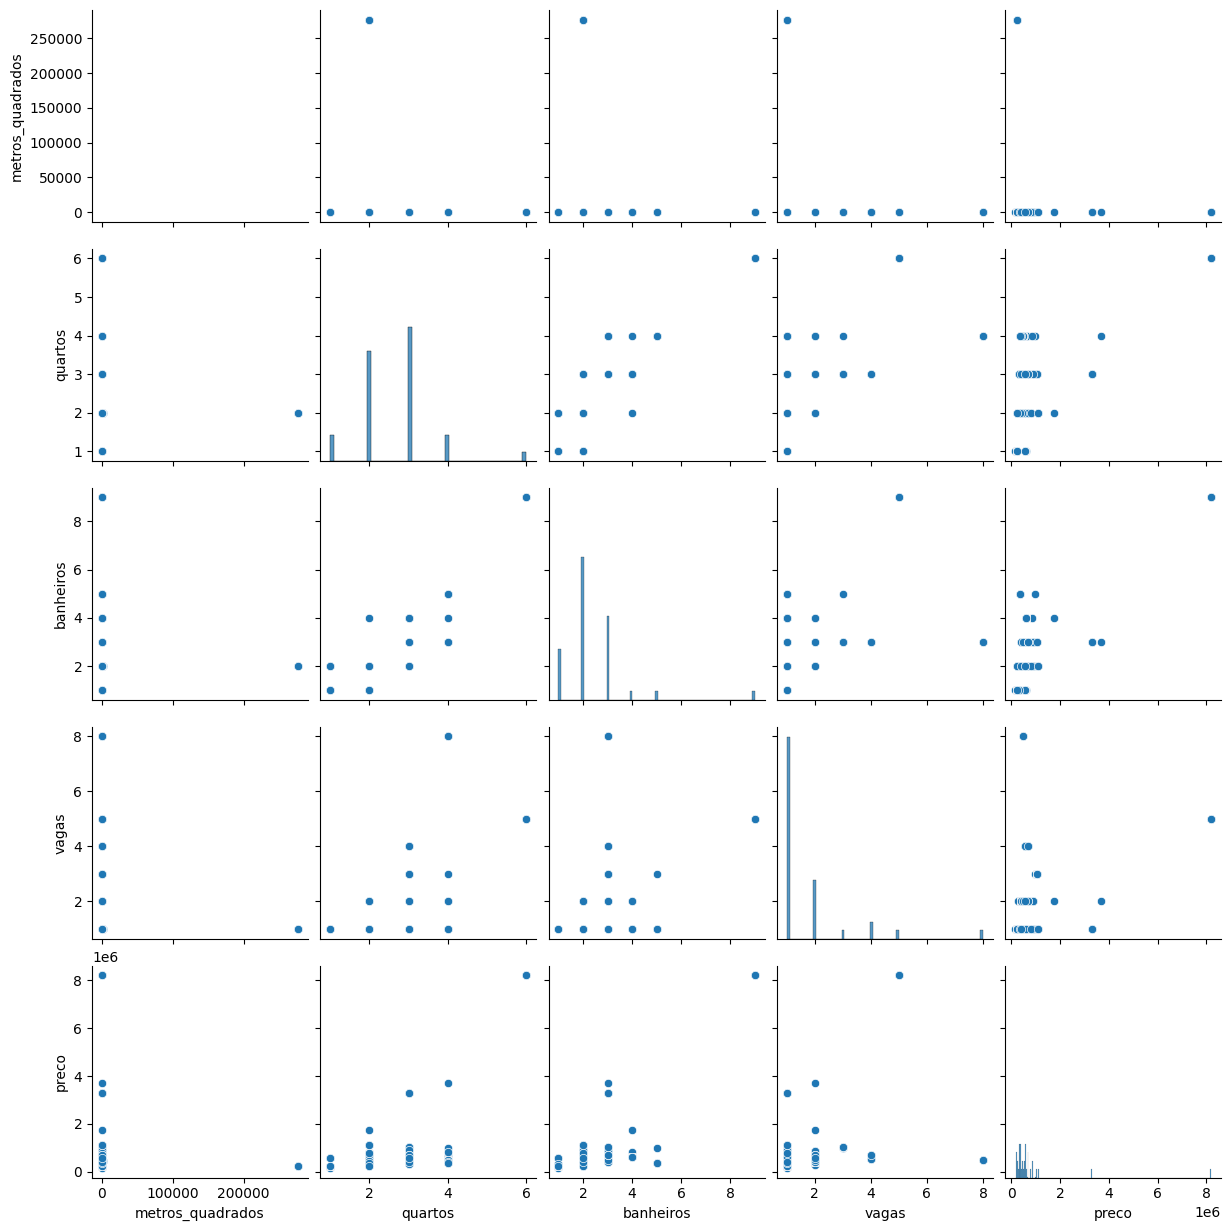

In [88]:
sns.pairplot(df)

In [174]:
df.columns

Index(['metros_quadrados', 'quartos', 'banheiros', 'vagas', 'preco', 'cidade',
       'estado'],
      dtype='object')

In [175]:
numerical_col = ['metros_quadrados','quartos','banheiros','vagas','preco']
categorical_col = ['cidade','estado']

In [176]:
outliers = detect_outliers(df[numerical_col], 0, df[numerical_col].columns)

In [177]:
df.drop(outliers, inplace=True)
df.reset_index(inplace=True,drop=True)

In [178]:
df.head()

,metros_quadrados,quartos,banheiros,vagas,preco,cidade,estado
0,69,2,1,1,310000.0,SAO BERNARDO DO CAMPO,SP
1,87,3,2,1,320000.0,GUARUJA,SP
2,50,2,1,1,232000.0,SAO PAULO,SP
3,117,2,2,1,580000.0,PORTO ALEGRE,RS
4,80,4,3,1,650000.0,CANELA,RS


<AxesSubplot: xlabel='metros_quadrados', ylabel='Count'>

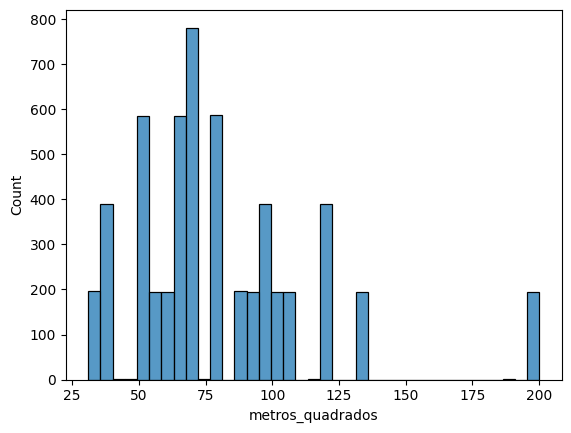

In [179]:
sns.histplot(data = df, x='metros_quadrados')

<AxesSubplot: xlabel='quartos', ylabel='Count'>

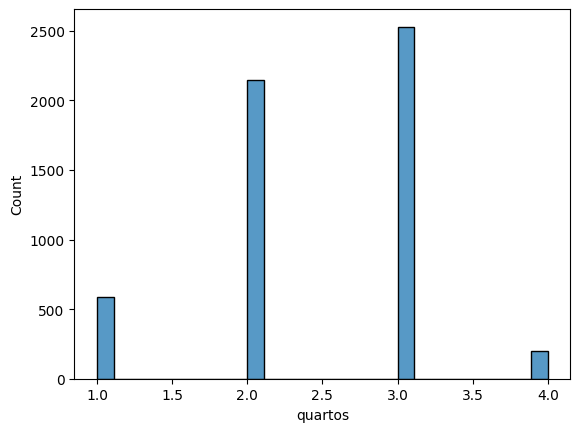

In [180]:
sns.histplot(data = df, x='quartos')

<AxesSubplot: xlabel='banheiros', ylabel='Count'>

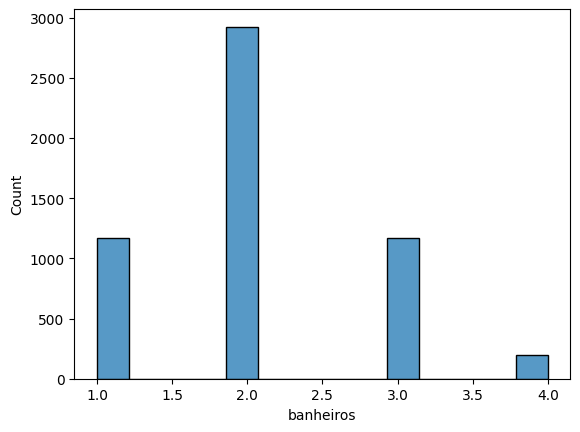

In [181]:
sns.histplot(data = df, x='banheiros')

<AxesSubplot: xlabel='vagas', ylabel='Count'>

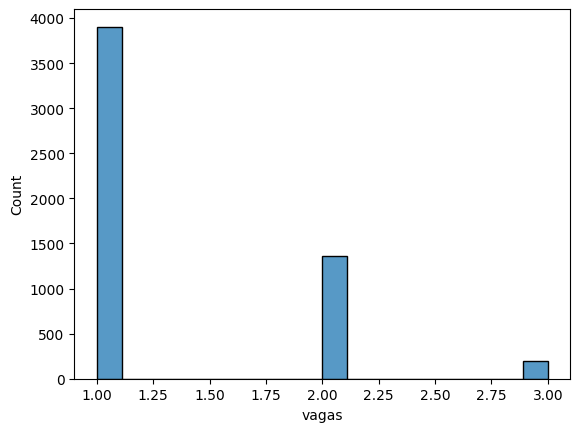

In [182]:
sns.histplot(data = df, x='vagas')

In [183]:
binary_encoder = ce.BinaryEncoder(cols=categorical_col)
df = binary_encoder.fit_transform(df)

In [184]:
new_df = pd.DataFrame(PowerTransformer().fit_transform(df), columns = df.columns, index = df.index)

In [185]:
X, y = new_df.drop('preco', axis=1) , new_df['preco']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=60)

In [186]:
reg = LinearRegression().fit(X_train, (y_train))

print('R-squared Train',round((reg.score(X_train, (y_train))*100),2),"%")
print('R-squared Test',round((reg.score(X_test, (y_test))*100),2),"%")

y_pred = reg.predict(X_test)

print(f'RMSE: {mean_squared_error(y_pred,(y_test))}')

R-squared Train 53.74 %
R-squared Test 52.0 %
RMSE: 0.48505925801134075


In [187]:
reg = ElasticNetCV().fit(X_train, (y_train))

print('R-squared Train',round((reg.score(X_train, (y_train))*100),2),"%")
print('R-squared Test',round((reg.score(X_test, (y_test))*100),2),"%")

y_pred = reg.predict(X_test)

print(f'RMSE: {mean_squared_error(y_pred,(y_test))}')

R-squared Train 53.73 %
R-squared Test 52.01 %
RMSE: 0.4849448145593748


In [188]:
reg = RidgeCV().fit(X_train, (y_train))

print('R-squared Train',round((reg.score(X_train, (y_train))*100),2),"%")
print('R-squared Test',round((reg.score(X_test, (y_test))*100),2),"%")

y_pred = reg.predict(X_test)

print(f'RMSE: {mean_squared_error(y_pred,(y_test))}')

R-squared Train 53.74 %
R-squared Test 52.0 %
RMSE: 0.48504727039927764


In [189]:
reg = LassoCV().fit(X_train, (y_train))

print('R-squared Train',round((reg.score(X_train, (y_train))*100),2),"%")
print('R-squared Test',round((reg.score(X_test, (y_test))*100),2),"%")

y_pred = reg.predict(X_test)

print(f'RMSE: {mean_squared_error(y_pred,(y_test))}')

R-squared Train 53.74 %
R-squared Test 52.01 %
RMSE: 0.484955647129214
